## `__code__`

In [1]:
import numpy as np                               # Math    - Numpy
import pandas as pd                              # Searies - Pandas
import matplotlib.pyplot as plt                  # Ploti`ang with Mat_Plot_Lib 

from IPython.display import display, Markdown    # Represantation
from itertools import product
import json
from math import ceil as roundup

from statsmodels.tsa.ar_model import AR             # АР 
from statsmodels.tsa.arima_model import ARMA        # АКРС
from statsmodels.tsa.api import pacf as PACF        # ЧАКФ 
from statsmodels.tsa.api import acf as  ACF         # AКФ 
import statsmodels.graphics.tsaplots as tsaplots    # АКФ та ЧАКФ графіки
from statsmodels.regression.linear_model import OLS

from statsmodels.stats.stattools import durbin_watson 
from scipy.stats import linregress


from random import shuffle

In [2]:
large = 19

%matplotlib inline 
params = {
    'axes.titlesize'   : large,
    'legend.fontsize'  : large,
    'figure.figsize'   : (22, 14),
    'axes.labelsize'   : large,
    'axes.titlesize'   : large,
    'xtick.labelsize'  : large,
    'ytick.labelsize'  : large,
    'figure.titlesize' : large,
    'lines.linewidth'  : 3.0
}
plt.rcParams.update(params) 
plt.style.use('seaborn-whitegrid')

_ = plt.xkcd()

In [3]:
def results():
    """ створює шаблон для таблиці результатів """
    return pd.DataFrame(
        data=np.zeros((4,4)),
        columns=["R - squared", "Residual Sum of Squares", "Akaike", "Durbin – Watson"],
        index=["$ma_5$", "$m_{10}$", "$ma_{5}^E$", "$ma_{10}^E$"]
    )

def showstats(s):
    " вивід пар ключ/значення "
    maxlen = max([len(k) for k in s.keys()])
    for k, v in s.items():
        print( "{0:<{2}}: {1}".format(k, v, maxlen))

In [4]:
# ploting

def y_acf_pacf(y, extra=[], lags=None, figsize=(21,16), chart=None, title=None):
    """ малює серію та графіки акф та чакф"""

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)

    ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2, rowspan=1)
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    if not title:
        title = 'Часовий ряд'
    ts_ax.set_title(title)
    ts_ax.plot(y, color="r")
    
    y_avg = (y.max() - y.min()) / 10
    y_s, y_e = 0 if y.min() - y_avg > 0 else y.min() - y_avg, y.max()+y_avg
    ts_ax.set_ylim(y_s, y_e)
    ts_ax.set_xlim(0, len(y))
    
    
     
#     bgcm ykw
    colors = list('bgcmk')
    shuffle(colors)
        
    for i in range(len(extra)):
        ts_ax.plot(extra[i][0], color=colors[i], label=extra[i][1])
    
    ts_ax.legend(loc="best")
    
    _acf  = ACF(y, nlags=lags)
    _pacf = PACF(y, nlags=lags)
    
    y_max = (_acf.max() if _acf.max() > _pacf.max() else _pacf.max()) + .1
    y_min = (_acf.min() if _acf.min() < _pacf.min() else _pacf.min()) - .5
    
    tsaplots.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, title="Автокореляція")
    acf_ax.set_ylim(y_min, y_max)
    tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, title="Часткова Автокореляція")
    pacf_ax.set_ylim(y_min, y_max)
    fig.tight_layout()
    
def plotter(*args):
    """ створює кілька графіків по кожному датафрейму """
    
    def values(x, typeof):
        if typeof in (pd.core.frame.DataFrame, pd.core.series.Series):
            return x.values
        if typeof in (np.ndarray,):
            return x.tolist()
        return x
        
    limit = 0
    for x in args:  
        vs = values(x[0], type(x[0]))
        plt.plot(vs, label=x[1])
        limit = len(vs)

    plt.xlim(0, limit)
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()
    
    
def allplots(x, predictions, figsize=(21,21), title=None):
    fig = plt.figure(figsize=figsize)
    
    total = len(predictions)
    extra = roundup(len(predictions)/2)
    layout = (1+extra, 2)
     
    #  оригінальний часовий ряд    
    ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2)
    
    if not title:
        title = 'Часовий ряд'
    ts_ax.set_title(title)
    ts_ax.plot(x)    
    x_avg = (x.max() - x.min()) / 10
    x_s, x_e = 0 if x.min() - x_avg > 0 else x.min() - x_avg, x.max()+x_avg
    ts_ax.set_ylim(x_s, x_e)
    ts_ax.set_xlim(0, len(x))
    
    def place(i):
        return 1+(i//2), i%2
    
    def colspan(i):
        return 2 if (i+1)%2 == 1 and i+1 == total else 1
    
    ax = []
    for i in range(len(predictions)):
        ax.append( plt.subplot2grid(layout, place(i), colspan=colspan(i)) )
        ax[-1].plot( predictions[i][0])
        ax[-1].set_title( predictions[i][1] )
        ax[-1].set_xlim(0, len(x)) 
        ax[-1].set_ylim(0, x.max()+100) 
    fig.tight_layout()
        

In [5]:
# Побудова моделей та функції помічники

def arma(values, p, q, ma_type, n):
    df = pd.DataFrame()
    df['values'] = values
    
    ar_model = AR(values).fit(p)
    ar_params = ar_model.params
    model_key = "AP({})".format(p)
    
    df[model_key] = np.nan
    df[model_key].iloc[p:] = ar_model.predict()
    df['Residuals'] = np.nan
    df['Residuals'].iloc[p:] = ar_model.resid
    
    
    def ma(seria):
        if ma_type == "exp":
            return seria.ewm(alpha=2/(n+1), min_periods=n, adjust=False).mean()
        return seria.rolling(window=n, min_periods=n).mean()
     
    Key = "MA_{}_{}".format(ma_type, n)
    df[Key] = ma(df['Residuals'])
    df['MA'] = df[Key]
    df['Y'] = df['Residuals'] - df[Key]
    
    # ordinary least squares
    X = np.zeros((len(df[Key])-q, q))
    for i in range(q):
        X[:, i] = df[Key][q-i-1:len(df[Key])-i-1]
    X = X[n+q:]
    Y = df['Y'].values[len(df['Y'])-len(X):]
    lin_reg = OLS(Y, X).fit()
    ma_params = lin_reg.params
    ma_predicts = lin_reg.predict().reshape(-1,)
    
    df['MA_Prediction'] = np.nan
    df['MA_Prediction'][len(df['MA_Prediction'])-len(ma_predicts):] = ma_predicts
    df['Predictions'] = df[model_key] + df['MA_Prediction'] + df[Key]
    df['error'] =  df['values'] - df['Predictions']
    
    cut = len(df['values']) - len(df['Predictions'].dropna().values)
    
    results = {
        'Parameters for AR(p)': list(ar_params),
        'Parameters for MA(N)': list(ma_params),
        'R-squared':  rsquared(df['values'][cut:], df['Predictions'][cut:]),
        'Residual Sum of Squares': residual_sum_of_squares(df['error'].dropna().values), 
        'Akaike': akaike(df['error'].dropna(), p, q, cut),
        'Durbin-Watson': durbin_watson(df['error'].dropna()), 
    }
    
    return df, results


def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2


def residual_sum_of_squares(resid):
    return np.linalg.norm(resid) ** 2


def akaike(resid, p, q, N):
    return N * np.log(residual_sum_of_squares(resid)) + 2 * (p + q + 1)

## Лаб #1 - `Побудова адекватного рівняння для опису процесу`

Для кожного часового ряду згідно варіанту побудуйте рівняння АРКС яке найбільш адекватно описує відповідний набір даних (дивиться алгоритм підбора рівняння).

In [6]:
file=1998

In [7]:
df = pd.read_csv('data/{}rts1.txt'.format(file), header=None, names=[file])
# df.describe()

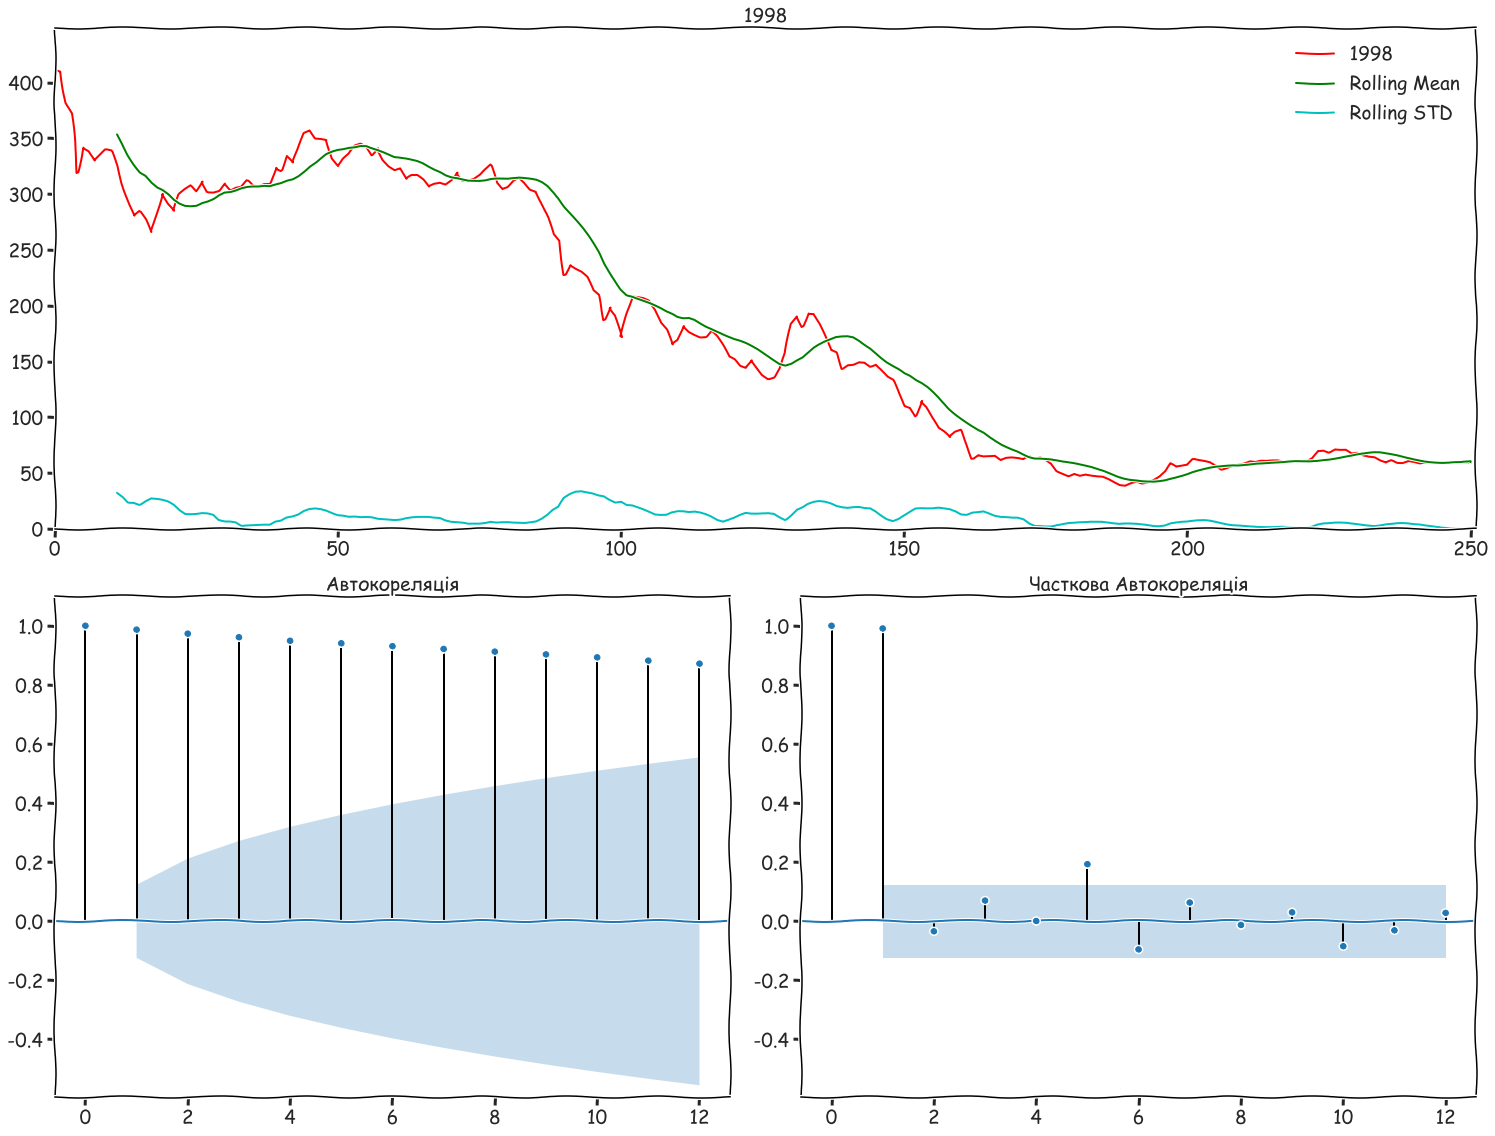

In [8]:
# будуємо графік для початкого ознайомлення з даними
extra = []
extra.append((df.rolling(window=12, center=False).mean(), "Rolling Mean"))
extra.append((df.rolling(window=12, center=False).std(), "Rolling STD"))

# ploting data, afc and pacf
y_acf_pacf(df[file], extra=extra, lags=12, title=file)

### Побудова `АРКС(p,q)` коли `КС` будується по залишкам `АР(p)` рівняння моделі

#### Визначення $p$ - порядку авто регресійної складової. 
- Обчисліть `АКФ` та `ЧАКФ` для 12 лагів часового ряду
- По отриманим значенням `АКФ` та **`ЧАКФ`** визначте $p$ -порядок авто регресійної складової.
    
*ref:*
* [Building Statistical Models Using StatsModels](https://www.pluralsight.com/courses/statsmodels-building-statistical-models)
* [Анализ временных рядов с помощью python](https://habr.com/ru/post/207160/)
* [ARIMA modelling in R](https://otexts.com/fpp2/arima-r.html)
* [Partial Autocorrelation Function (PACF)](https://newonlinecourses.science.psu.edu/stat510/node/62/)
* [Identifying the numbers of AR or MA terms in an ARIMA model](http://people.duke.edu/~rnau/411arim3.htm)
* [Time Series ARIMA(p,d,q) - how to determine what p, d and q equal?](https://www.talkstats.com/threads/27541/)

`ЧАКФ` (часткова автокореляційна функція) дозволе нам визначити $p^-$. По її корелограмі можна буде визначити кількість лагів сильно відмінних від 0 в моделі `AP`.

Як бачимо після 1-го лагу `ЧАКФ` перестає бути важливою, а отже $p=1$

In [9]:
p=2

#### Визначення $q$ - порядку КС.

- Обчисліть коефіцієнти моделі `АР(p)` : $y(k) = a_0 + \sum\limits_{i=1}^p y (k - i)$.
- Обчисліть коефіцієнти `АКФ` та `ЧАКФ` для 12 лагів залишків моделі `АР(p)`.
- По отриманим значенням **`АКФ`** та `ЧАКФ` визначте $q$ - порядок `КС`.


In [1]:
model = AR(df[file].values).fit(p)
prediction = model.predict()

plt.plot(prediction)
plt.plot(df[file].values)
_ = plt.show()

NameError: name 'AR' is not defined

In [11]:
model.params

array([ 0.21679591,  1.07349181, -0.08186926])

No handles with labels found to put in legend.


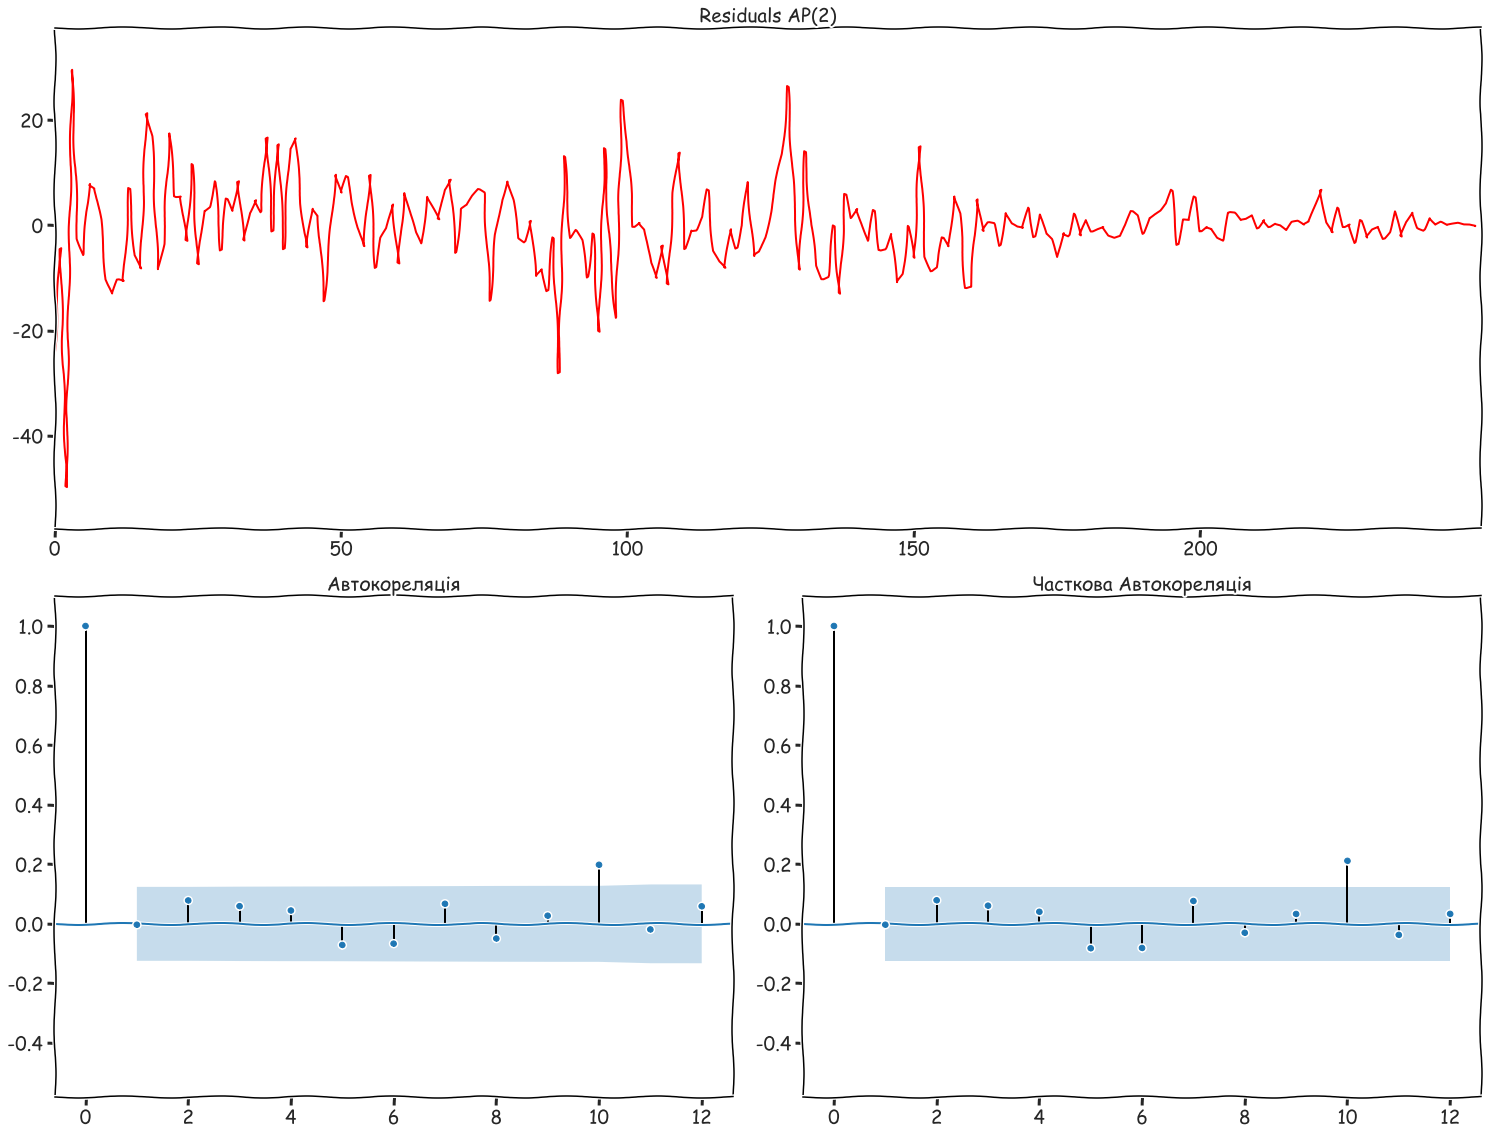

In [12]:
y_acf_pacf(model.resid, lags=12, title="Residuals AP({})".format(p))

Згідно корелограмми АКФ для залишків моделі AP(2) порядок $q^-=2$

#### Підхід #1 - Застосування стандартного КС

Побудуйте рівняння `APKC(p,q)`. Отримані результати занесіть в таблицю. 
Буде отримано чотири рівняння: 

1. просте КС з $N = 5$
1. просте КС з $N=10$
1. експоненційне КС з $N = 5$  
1. експоненційне КС з $N = 10$ 

In [13]:
# оскільки показники - грають не дуже 
p=2
q=1
dfr = results()

_ = display(Markdown("### Початкова (незаповнена таблиця для) ARMA({},{})".format(p, q)))
dfr

### Початкова (незаповнена таблиця для) ARMA(2,1)

,R - squared,Residual Sum of Squares,Akaike,Durbin – Watson
$ma_5$,0.0,0.0,0.0,0.0
$m_{10}$,0.0,0.0,0.0,0.0
$ma_{5}^E$,0.0,0.0,0.0,0.0
$ma_{10}^E$,0.0,0.0,0.0,0.0


In [14]:
df_ma_5, stats = arma(df[file].values, p=p, q=q, ma_type="normal", n=5)
dfr.iloc[0, :] = stats['R-squared'], stats['Residual Sum of Squares'], stats['Akaike'], stats['Durbin-Watson']
showstats(stats)

Parameters for AR(p)   : [0.21679590597544263, 1.0734918104398594, -0.08186926478532738]
Parameters for MA(N)   : [-0.6582419360814271]
R-squared              : 0.9974228440432239
Residual Sum of Squares: 7724.487195697255
Akaike                 : 70.66505501989965
Durbin-Watson          : 2.0306315969471567


In [15]:
df_ma_10, stats = arma(df[file].values, p=p, q=q, ma_type="normal", n=10)
dfr.iloc[1, :] = stats['R-squared'], stats['Residual Sum of Squares'], stats['Akaike'], stats['Durbin-Watson']
showstats(stats)

Parameters for AR(p)   : [0.21679590597544263, 1.0734918104398594, -0.08186926478532738]
Parameters for MA(N)   : [-0.6046076258844387]
R-squared              : 0.9964389655197788
Residual Sum of Squares: 10198.115503221681
Akaike                 : 118.75949873140426
Durbin-Watson          : 1.9187104695107113


In [16]:
df_exp_5, stats = arma(df[file].values, p=p, q=q, ma_type="exp", n=5)
dfr.iloc[2, :] = stats['R-squared'], stats['Residual Sum of Squares'], stats['Akaike'], stats['Durbin-Watson']
showstats(stats)

Parameters for AR(p)   : [0.21679590597544263, 1.0734918104398594, -0.08186926478532738]
Parameters for MA(N)   : [-0.5265572318519416]
R-squared              : 0.9982070012482005
Residual Sum of Squares: 5383.317142183978
Akaike                 : 68.13742022634028
Durbin-Watson          : 1.9603310242104481


In [17]:
df_exp_10, stats = arma(df[file].values, p=p, q=q, ma_type="exp", n=10)
dfr.iloc[3, :] = stats['R-squared'], stats['Residual Sum of Squares'], stats['Akaike'], stats['Durbin-Watson']
showstats(stats)

Parameters for AR(p)   : [0.21679590597544263, 1.0734918104398594, -0.08186926478532738]
Parameters for MA(N)   : [-0.5668880419536796]
R-squared              : 0.9972400132081818
Residual Sum of Squares: 7917.388850508671
Akaike                 : 115.72180087827488
Durbin-Watson          : 1.9492151226447618


### Графічне зображення передбичення по простому MA відносно Часового рядку

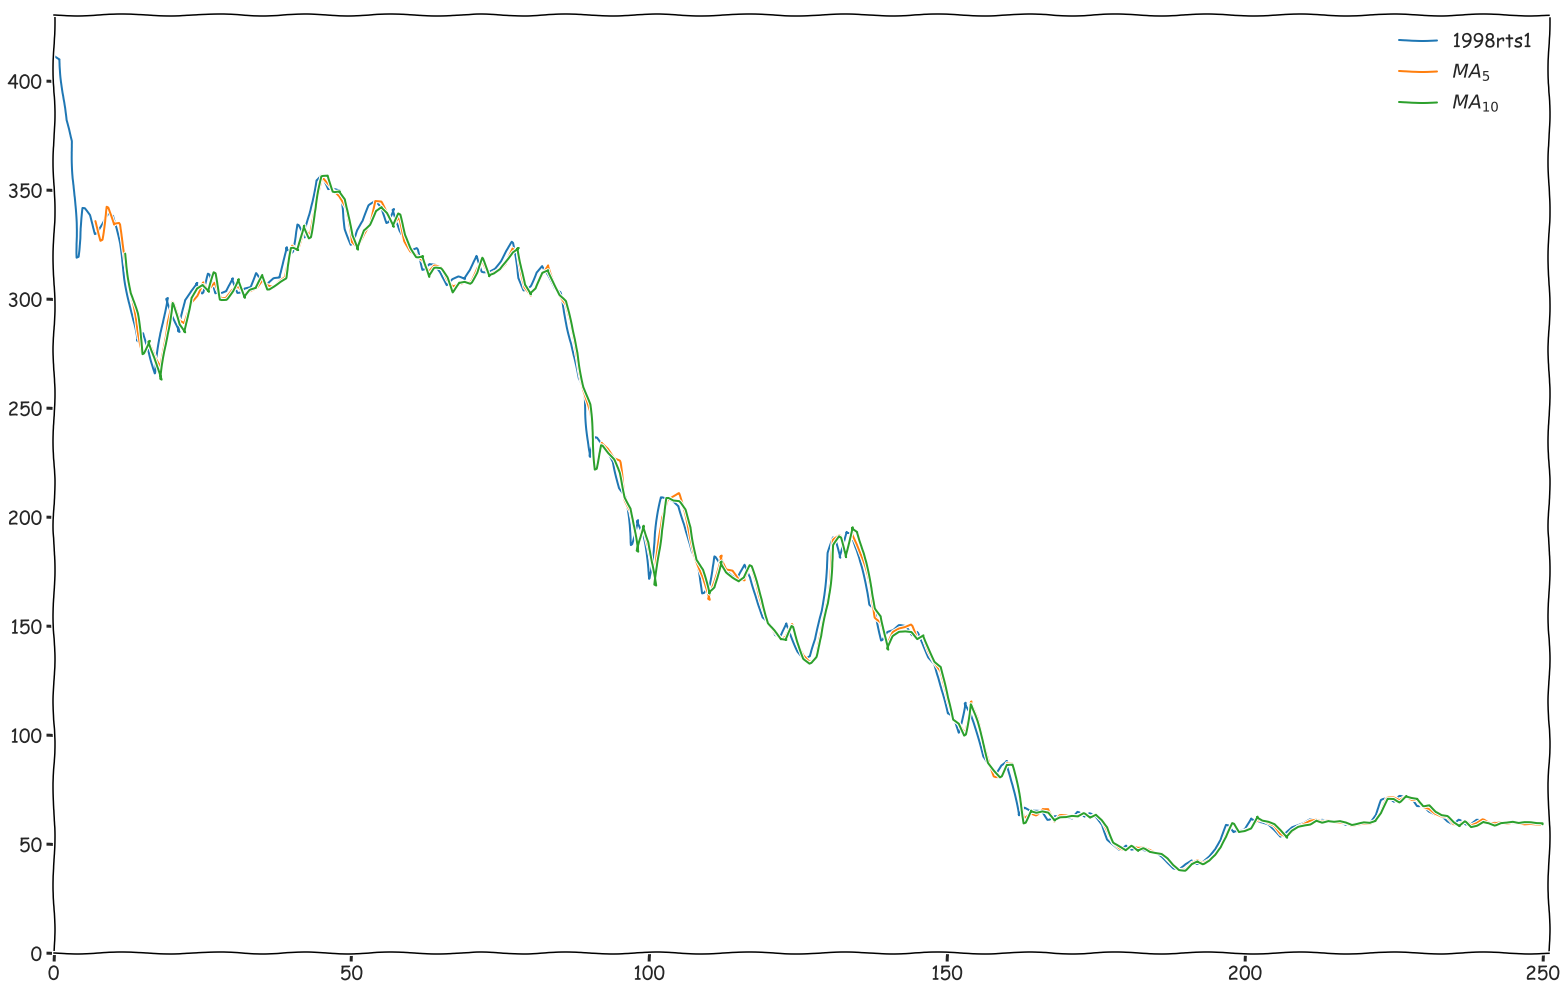

In [18]:
# key_to_show = MA_normal_5
_ = display(Markdown("### Графічне зображення передбичення по простому MA відносно Часового рядку"))

key_to_show = 'Predictions'
plotter(
    [df.values, "{}rts1".format(file)],
    [df_ma_5[key_to_show].values, "$MA_5$"],
    [df_ma_10[key_to_show].values, "$MA_{10}$"], 
)

### Графічне зображення передбичення по експоненційному MA відносно Часового рядку

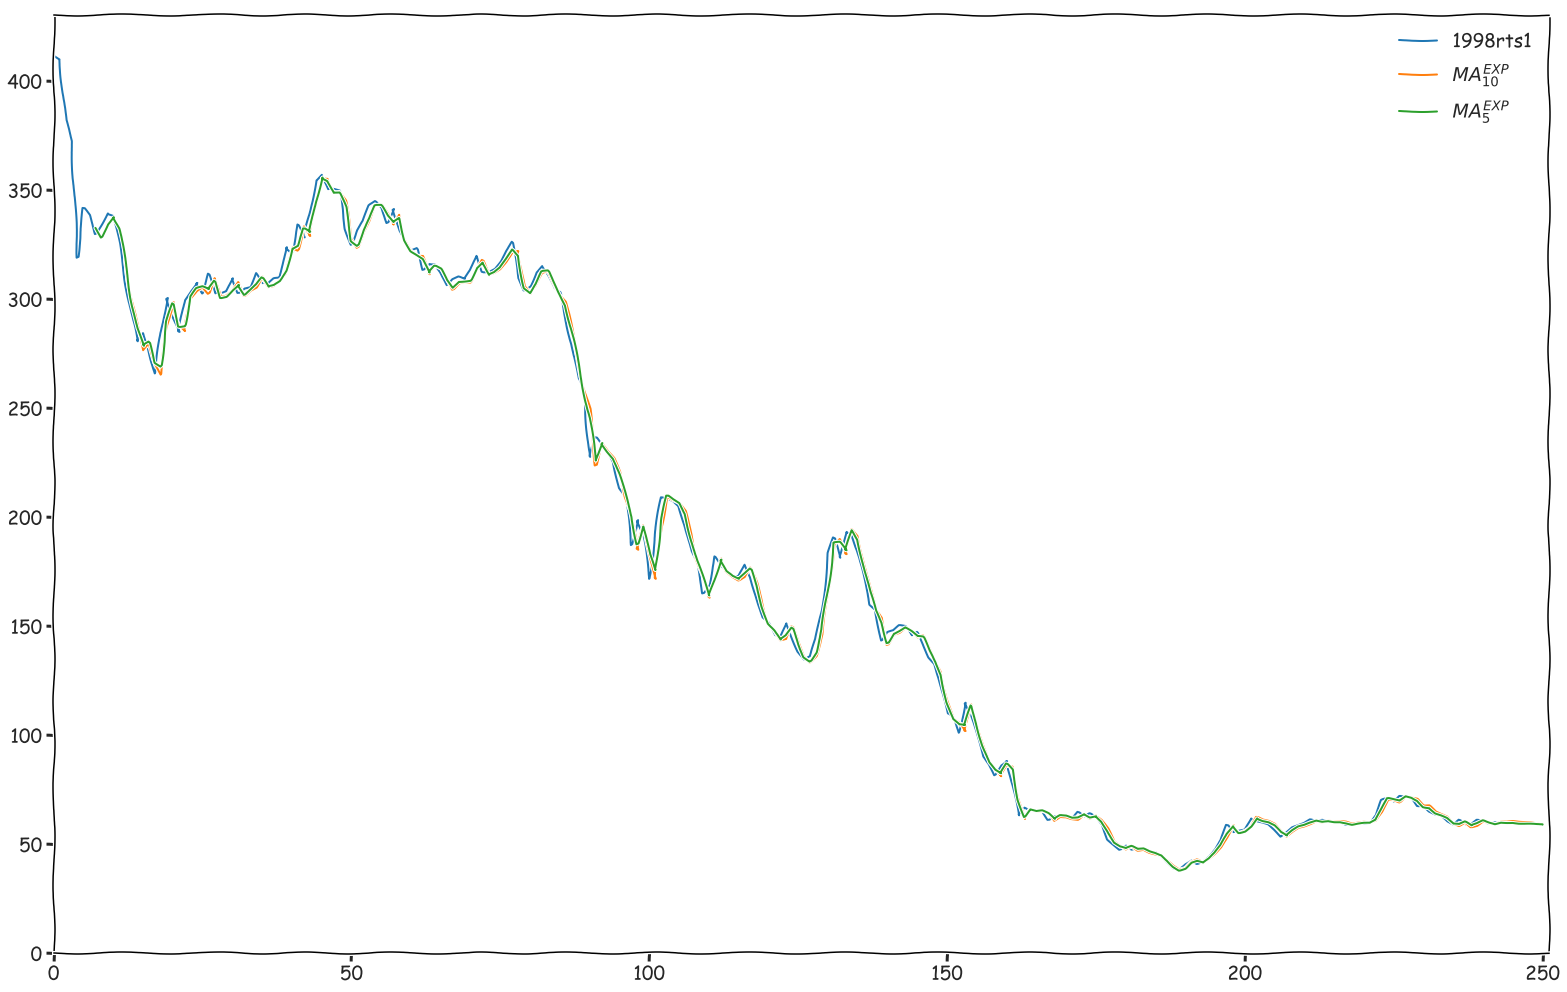

In [19]:
_ = display(Markdown("### Графічне зображення передбичення по експоненційному MA відносно Часового рядку"))

# key_to_show = MA_normal_5
key_to_show = 'Predictions'
plotter(
    [df.values, "{}rts1".format(file)], 
    [df_exp_10[key_to_show].values, "$MA_{10}^{EXP}$"],
    [df_exp_5[key_to_show].values, "$MA_{5}^{EXP}$"],
)

### Графічне зображення по усіх рівняннях MA відносно Часового рядку

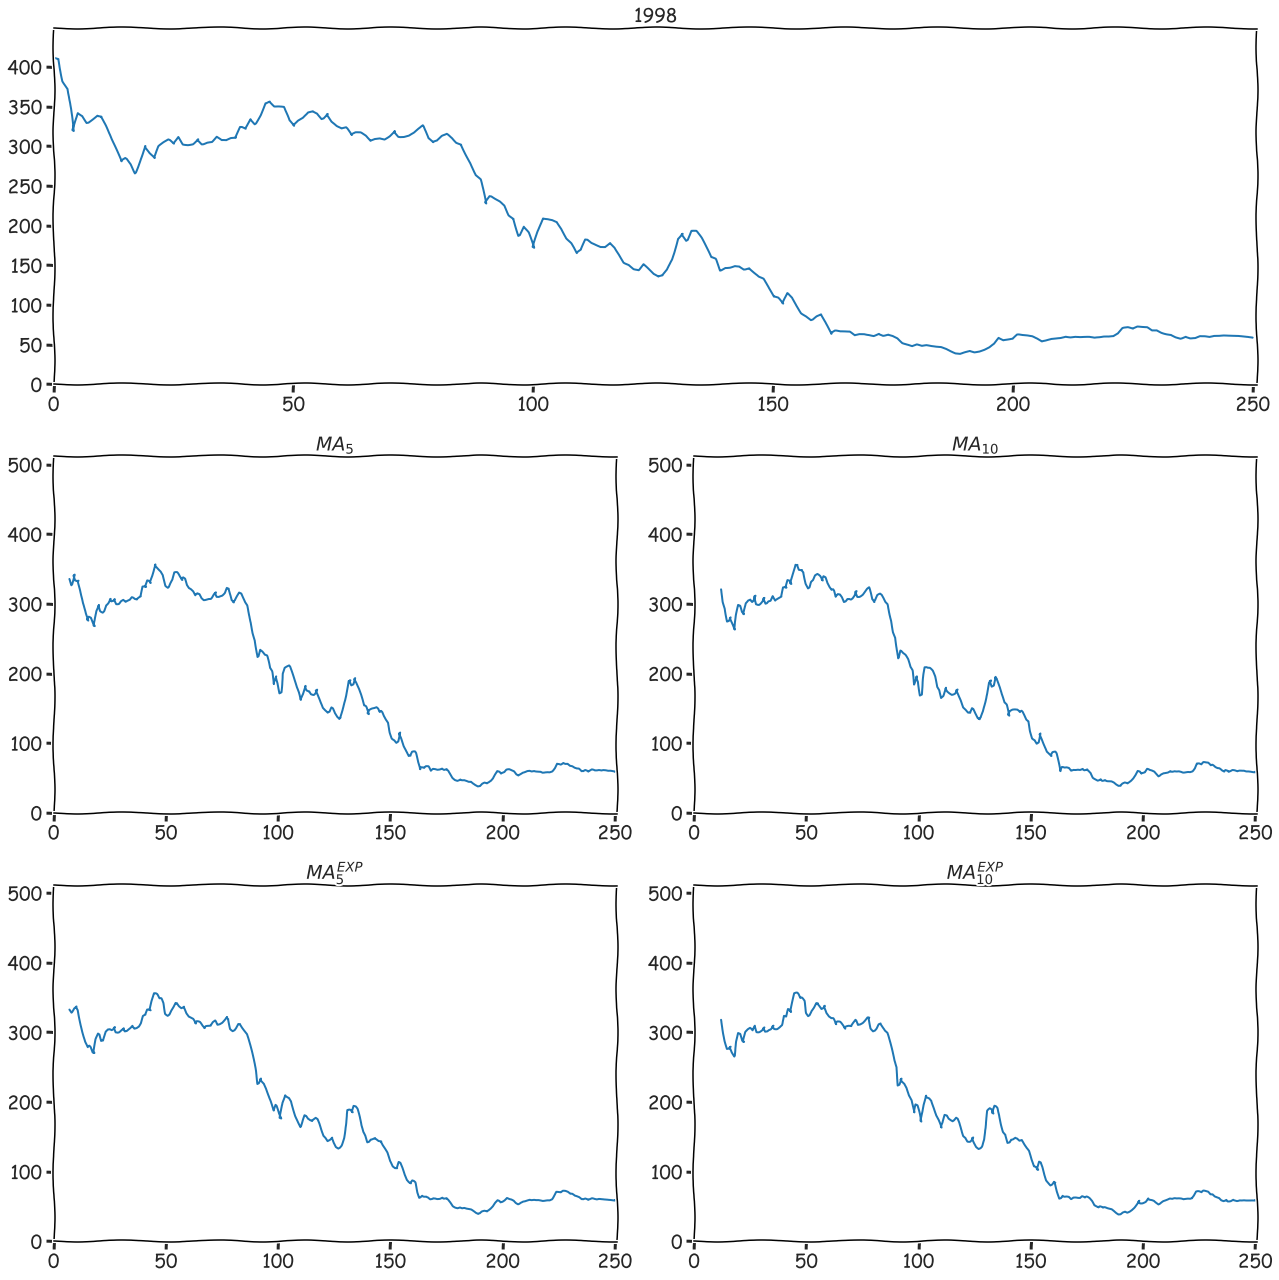

In [20]:
_ = display(Markdown("### Графічне зображення по усіх рівняннях MA відносно Часового рядку"))

allplots(df.values, predictions=[
    [df_ma_5[key_to_show].values, "$MA_5$"],
    [df_ma_10[key_to_show].values, "$MA_{10}$"],
    [df_exp_5[key_to_show].values, "$MA_{5}^{EXP}$"], 
    [df_exp_10[key_to_show].values, "$MA_{10}^{EXP}$"], 
], title="{}".format(file), figsize=(18,18))

In [21]:
dfr

,R - squared,Residual Sum of Squares,Akaike,Durbin – Watson
$ma_5$,0.997423,7724.487196,70.665055,2.030632
$m_{10}$,0.996439,10198.115503,118.759499,1.918710
$ma_{5}^E$,0.998207,5383.317142,68.137420,1.960331
$ma_{10}^E$,0.997240,7917.388851,115.721801,1.949215


## Побудова `АРКС(p,q)` коли `КС` будується по вихідному сигналу `у`

1. Визначення $p$ - порядку авто регресійної складової.
  - Обчисліть АКФ та ЧАКФ для 12 лагів часового ряду
  - По отриманим значенням АКФ та ЧАКФ визначте $p$ = порядок авто регресійної складової.
1. Побудова `КС` по $y$.
  - Побудуйте просте `КС` по `y` з розміром вікна `КС` $N = 5$ та $N = 10$. 
  - Побудуйте експоненційне `КС` по $y$ з розміром вікна `КС` $N = 5$ та $N = 10$
1. Визначення $q$ - порядку `КС`.
  - Для цього побудуйте `ЧАКФ(КС)` та визначте q .
1. Побудуйте `АРКС(p,q)`.

#### Підхід #1 - Застосування власних коефіцієнтів при `КС`.

Обчислить коефіцієнти $b_1, \dots, b_q$ за формулою:

$$ b_i = \dfrac{(1-\alpha)^i}{\sum\limits_{j=1}^q(1-\alpha)^j}$$

де $\alpha = \dfrac{2}{q+1}$


Після чого обчислить коефіцієнти рівняння:

$y_1(k) = y(k) - mv(k) - \sum \limits_{j=1}^q b_j mv(k-j) = a_0+\sum \limits_{i=1}^p a_i y(k-i)$ - де $mv$ - КС

#### Підхід #2 - Обчислення коефіцієнтів `АРКС(p,q)`.
В даному випадку коефіцієнти $b_1, \dots, b_q$ вважаються невідомими і їх необхідно обчислити разом з коефіцієнтами $a_0,a_1, \dots,a_p$.

$y(k) = a_o + \sum \limits_{i=1}^p a_i \times y (k-1) + mv(k) + \sum \limits_{j=1}^q b_i mv(k-j) $

#### Результати

Отримані результати занесіть в таблиці 2 та 3. Буде отримано чотири рівняння 

1. просте `КС` з $N = 5$
2. просте `КС` з $N = 10$ 
3. експоненційне `КС` з $N = 5$
4. експоненційне `КС` з $N = 10$

In [22]:
p = 2
dfr = results()

In [23]:
# оскільки показники - грають не дуже 
_ = display(Markdown("### Початкова (незаповнена таблиця для) по сигналу Y".format(p, q)))
dfr

### Початкова (незаповнена таблиця для) по сигналу Y

,R - squared,Residual Sum of Squares,Akaike,Durbin – Watson
$ma_5$,0.0,0.0,0.0,0.0
$m_{10}$,0.0,0.0,0.0,0.0
$ma_{5}^E$,0.0,0.0,0.0,0.0
$ma_{10}^E$,0.0,0.0,0.0,0.0


In [24]:
def signaly(seria, p, ma_type: str="exp", n: int=10, pacflangs:int=12):
    
    df = pd.DataFrame()
    df['values'] = seria
    
    def ma(seria):
        if ma_type == "exp":
            return seria.ewm(alpha=2/(n+1), min_periods=n, adjust=True).mean()
        return seria.rolling(window=n, min_periods=n).mean()
    
    Key = "MA_{}_{}".format(ma_type, n)
    df[Key] = ma(df['values'])
    
    y_acf_pacf(df[Key][n:], lags=pacflangs, title="$MA \qquad type={} \qquad lag={}$".format(ma_type, n))
    pacf_data = PACF(df[Key][n:], nlags=12)
    q = np.sum(pacf_data >= ( (1.96) / np.sqrt(len(df[Key][n:])) ) )
    
    _ = display(Markdown("### Згідно ЧАКФ для {} лагів часового ряду = $q^- {}$".format(pacflangs, q)))
    
    df['resid'] = df['values'] - df[Key]
   
    
    # ols arguments   

    def shifted(s, n):
        m = np.zeros((len(s)-n, n))
        for i in range(n):
            m[:, i] = s[n-i-1:len(df[Key])-i-1]
        return m
    
    ar = shifted(df['values'].values, p)
    ma = shifted(df[Key].values, q)[(n-1):]
    ar = ar[len(ar)-len(ma):]
    
    X = np.c_[np.ones((ar.shape[0], 1)), ar, ma]
    Y = df['resid'][len(df['values'])-len(ma):]
    lin_reg = OLS(Y, X).fit()
    params = lin_reg.params 
    
    ma_predict_key = "Y_{}_Predicts".format(Key)
    df['MA_Prediction'] = np.nan
    df['MA_Prediction'][len(df['values'])-len(ma):] = lin_reg.predict().reshape(-1,) 
    
    df['Predictions'] = df['MA_Prediction'] + df[Key]
    
    df['error']  = df['values'] - df['Predictions']
    
    cut = len(df['values']) - len(df['Predictions'].dropna().values)
    
    results = {
        'Parameters': list(lin_reg.params), 
        'R-squared':  rsquared(df['values'][cut:], df['Predictions'][cut:]),
        'Residual Sum of Squares': residual_sum_of_squares(df['error'].dropna().values), 
        'Akaike': akaike(df['error'].dropna(), p, q, cut),
        'Durbin-Watson': durbin_watson(df['error'].dropna()), 
    }
    
    return df, results


### Згідно ЧАКФ для 12 лагів часового ряду = $q^- 2$

Parameters             : [-0.12608508659529155, 0.9864549251889566, -0.13888871765172903, -1.3329289273438514, 0.4818466936083487]
R-squared              : 0.9974712698477619
Residual Sum of Squares: 7625.90653972298
Akaike                 : 63.635838909185054
Durbin-Watson          : 2.007461520342815


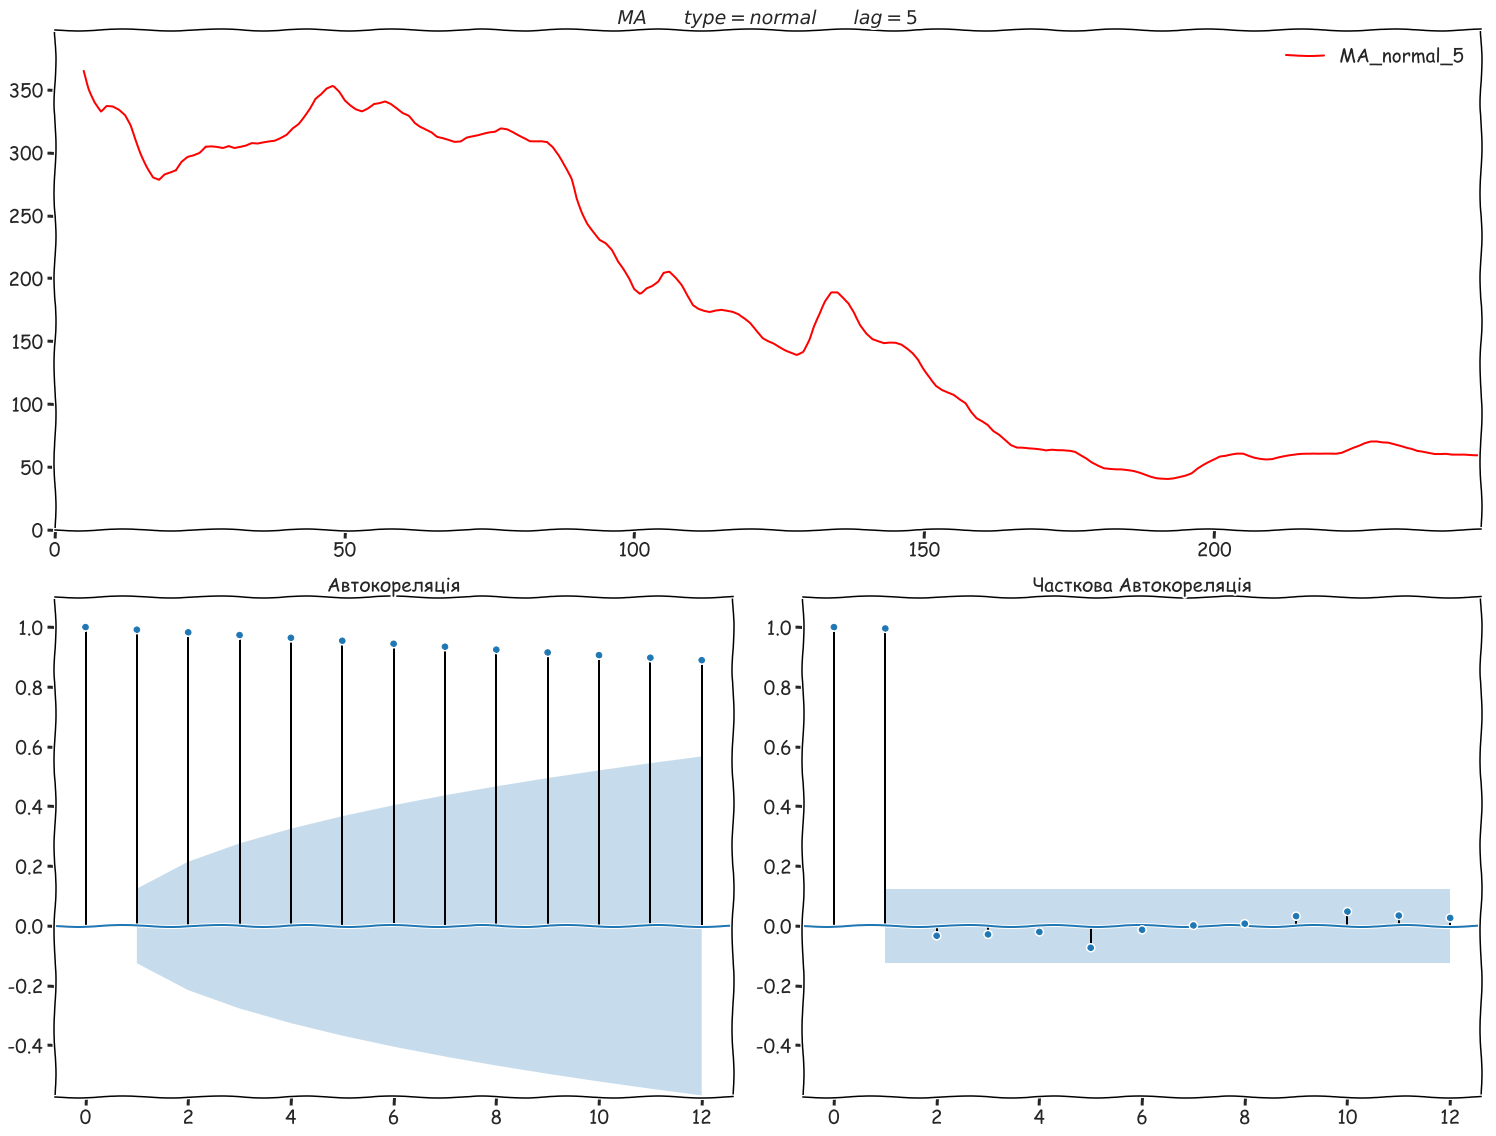

In [25]:
df_ma_5, stats = signaly(df[file].values, p=p, ma_type="normal", n=5)
dfr.iloc[0, :] = stats['R-squared'], stats['Residual Sum of Squares'], stats['Akaike'], stats['Durbin-Watson']
showstats(stats)

### Згідно ЧАКФ для 12 лагів часового ряду = $q^- 2$

Parameters             : [0.03074470910129226, 1.0572257957064637, -0.20518830341648003, -0.9964213137022802, 0.14048705956674143]
R-squared              : 0.9965302108712586
Residual Sum of Squares: 10008.847046239593
Akaike                 : 111.3234715402764
Durbin-Watson          : 2.0134923226268278


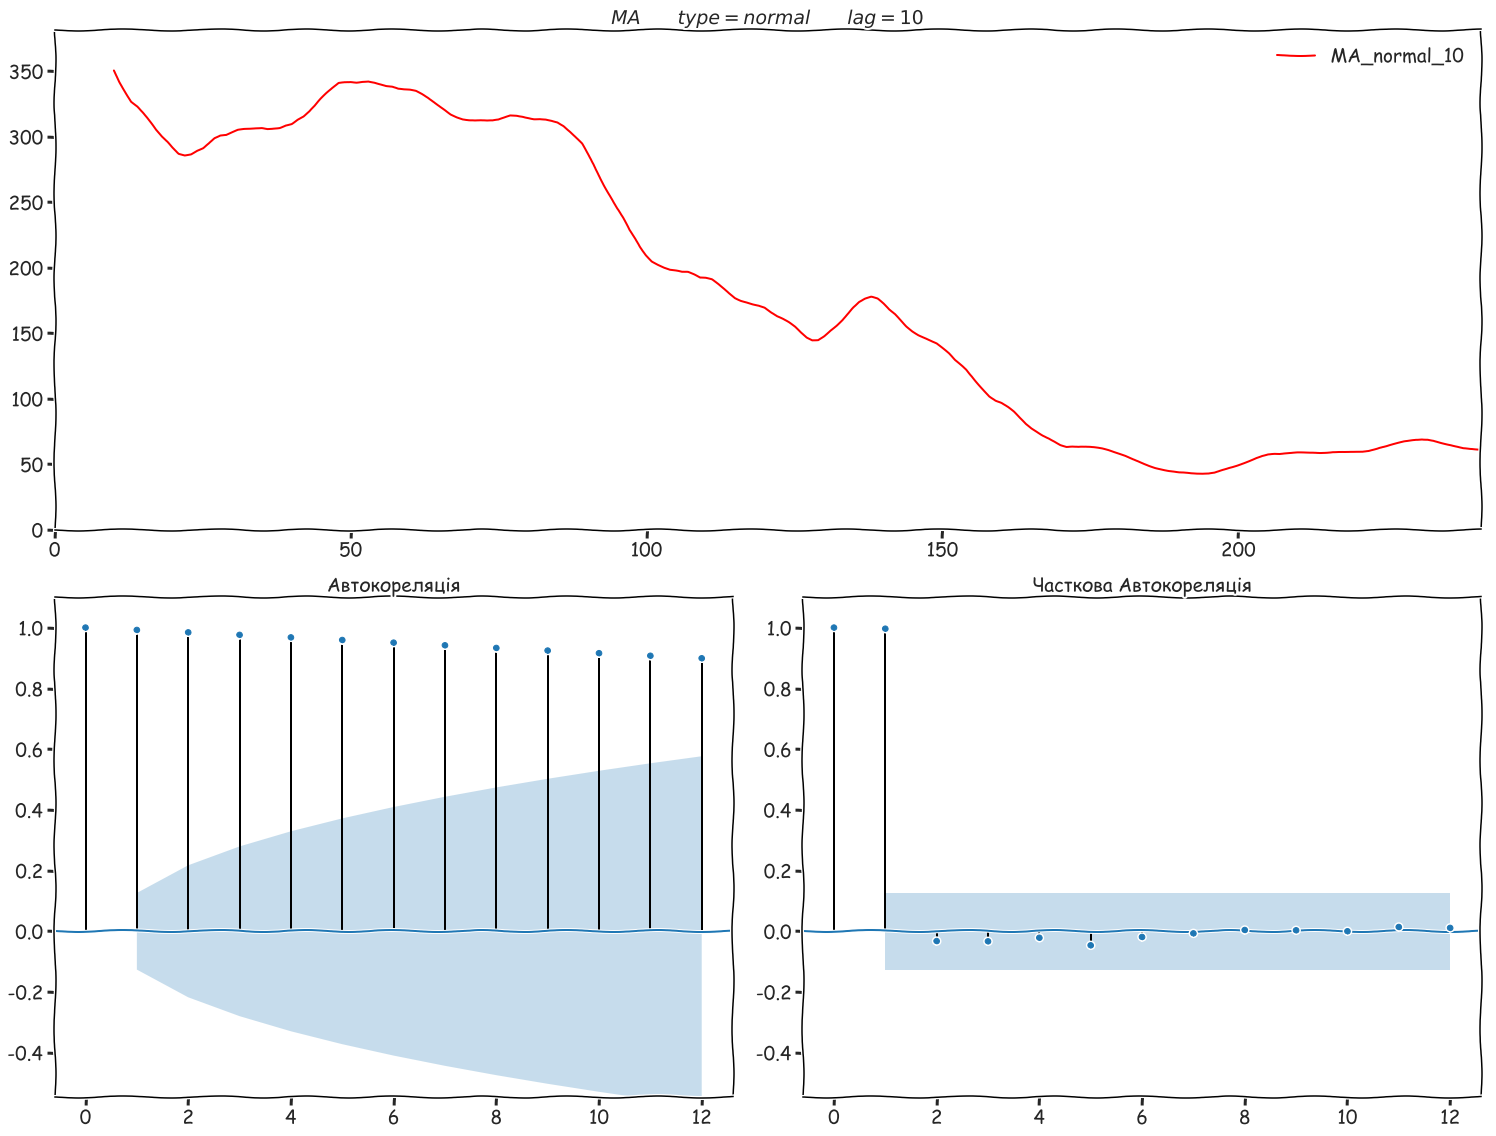

In [26]:
df_ma_10, stats = signaly(df[file].values, p=p, ma_type="normal", n=10)
dfr.iloc[1, :] = stats['R-squared'], stats['Residual Sum of Squares'], stats['Akaike'], stats['Durbin-Watson']
showstats(stats)

### Згідно ЧАКФ для 12 лагів часового ряду = $q^- 2$

Parameters             : [-0.10731906265989781, -0.3189353725150154, -0.08395830027482655, 2.599797091156769, -2.1995591981750486]
R-squared              : 0.998221644664674
Residual Sum of Squares: 5364.612454175093
Akaike                 : 61.52547649908634
Durbin-Watson          : 1.9878010488953854


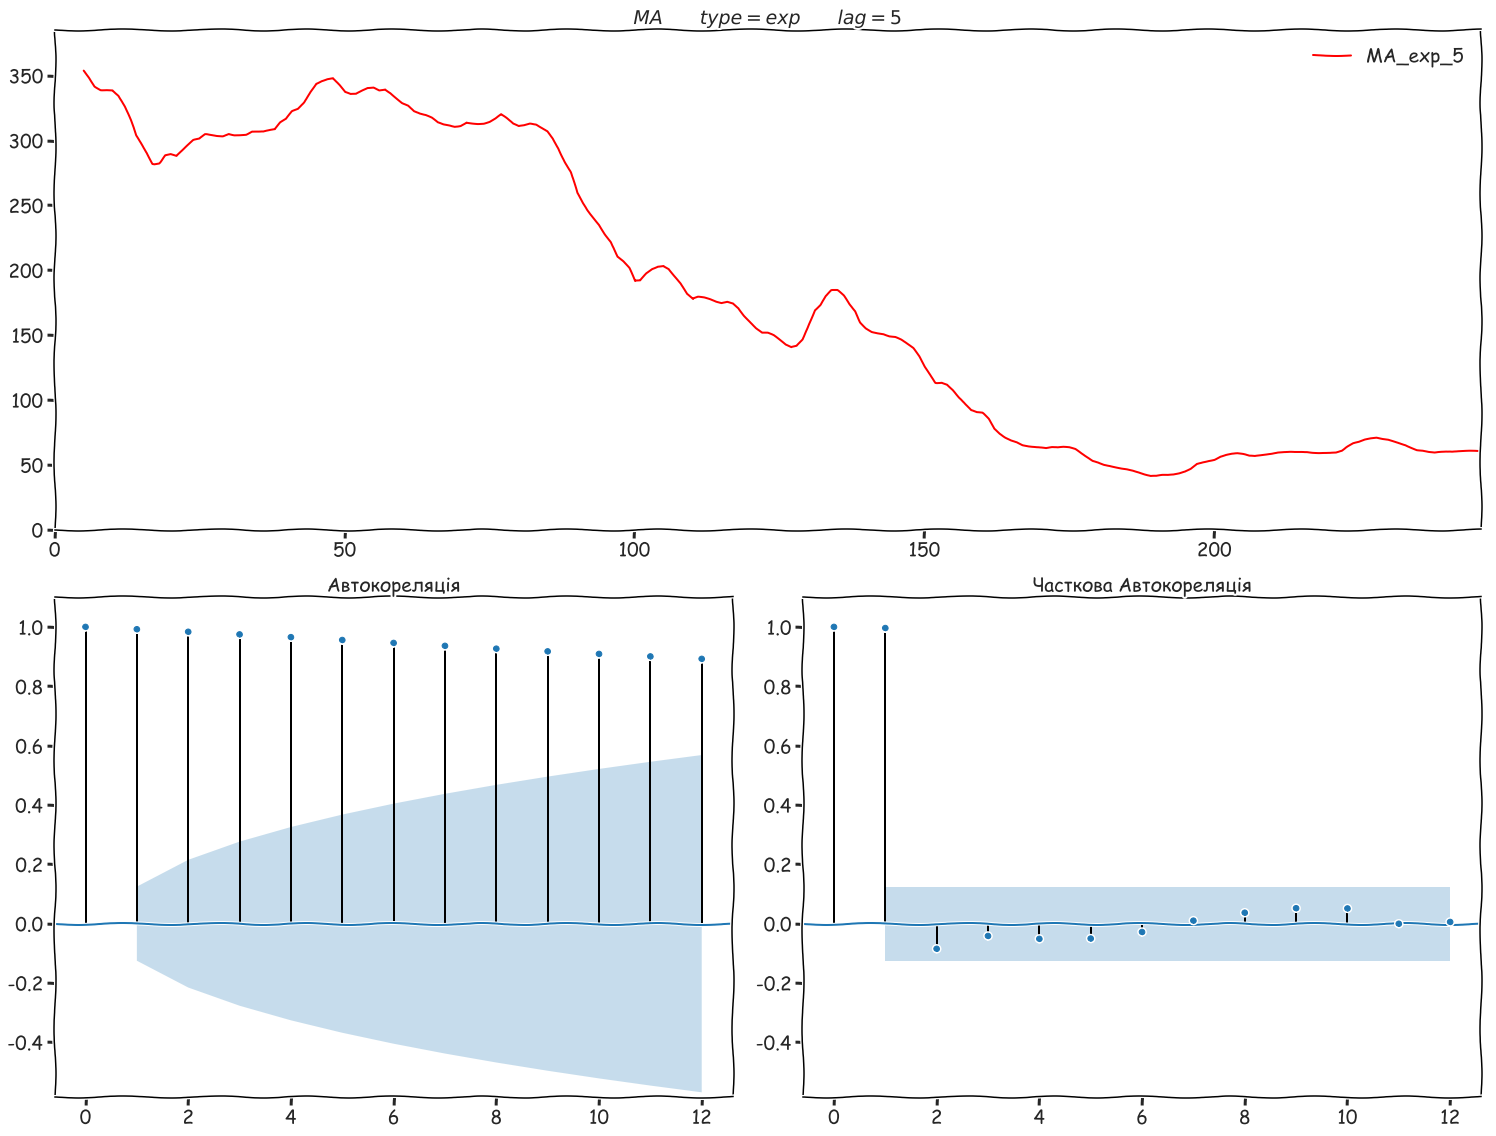

In [27]:
df_exp_5, stats = signaly(df[file].values, p=p, ma_type="exp", n=5)
dfr.iloc[2, :] = stats['R-squared'], stats['Residual Sum of Squares'], stats['Akaike'], stats['Durbin-Watson']
showstats(stats)

### Згідно ЧАКФ для 12 лагів часового ряду = $q^- 2$

Parameters             : [-0.20380658127369145, -0.6681771401031031, -0.10885764118497304, 7.982307390198709, -7.207976519766023]
R-squared              : 0.997259278302384
Residual Sum of Squares: 7906.710434043796
Akaike                 : 108.73013809924365
Durbin-Watson          : 1.978614124129776


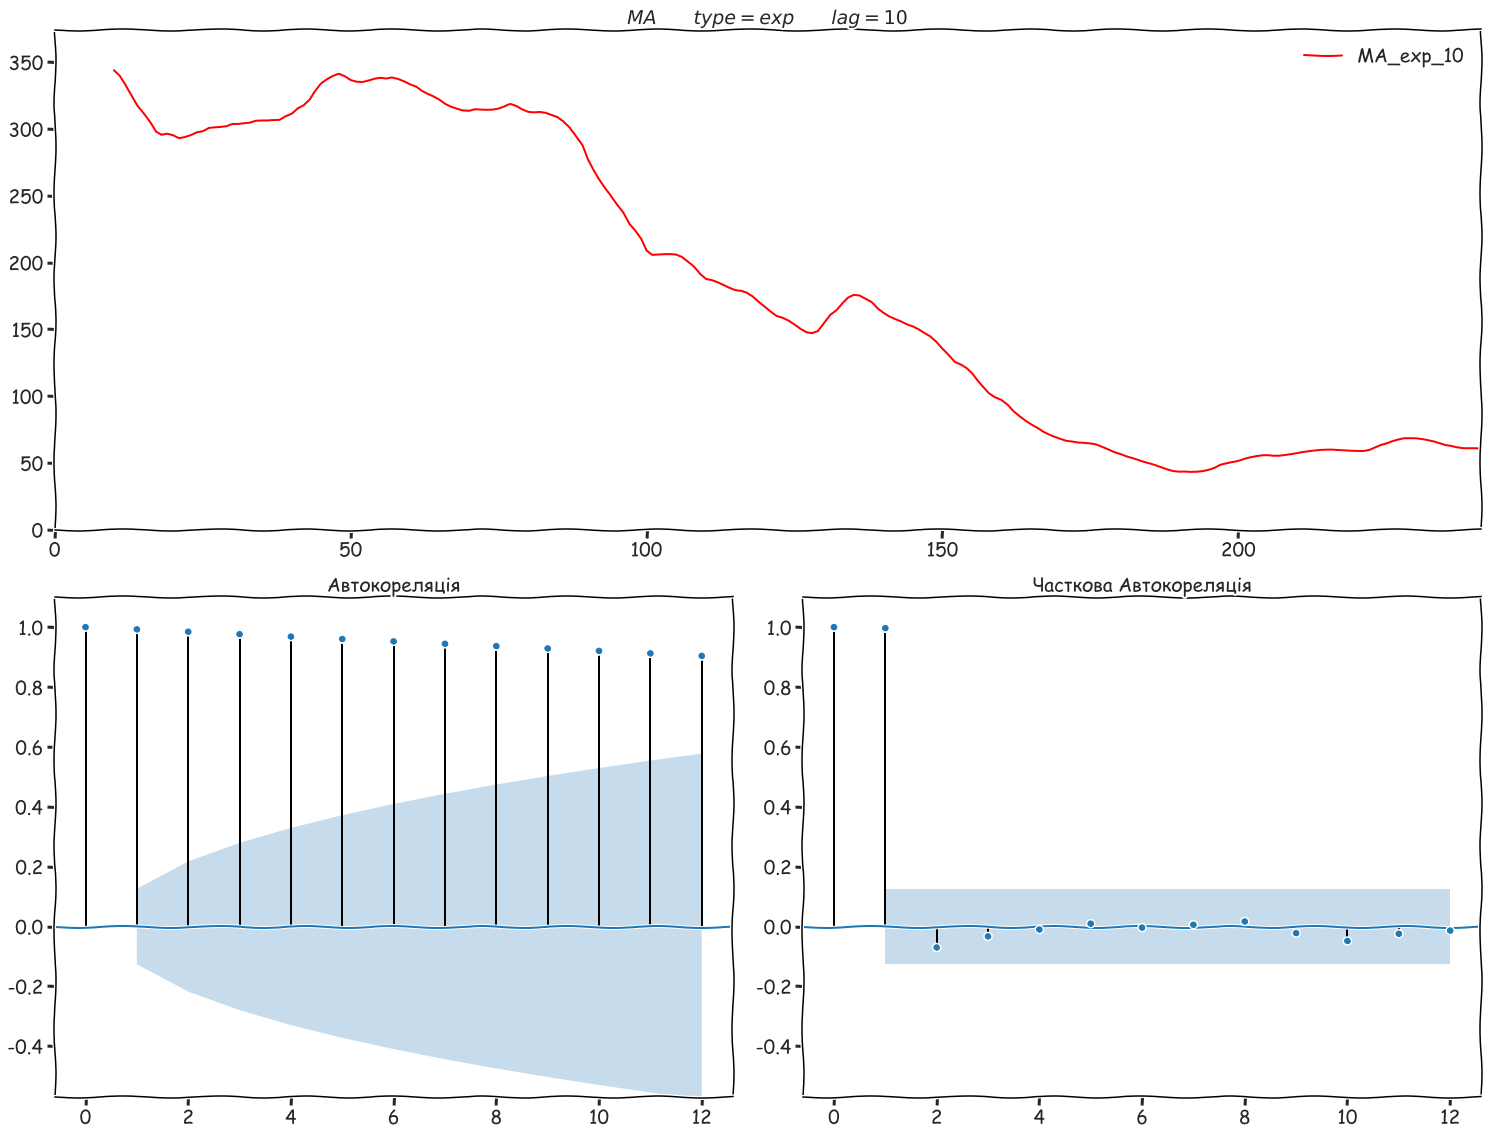

In [28]:
df_exp_10, stats = signaly(df[file].values, p=p, ma_type="exp", n=10)
dfr.iloc[2, :] = stats['R-squared'], stats['Residual Sum of Squares'], stats['Akaike'], stats['Durbin-Watson']
showstats(stats)

### Графічне зображення передбичення по простому MA відносно Часового рядку

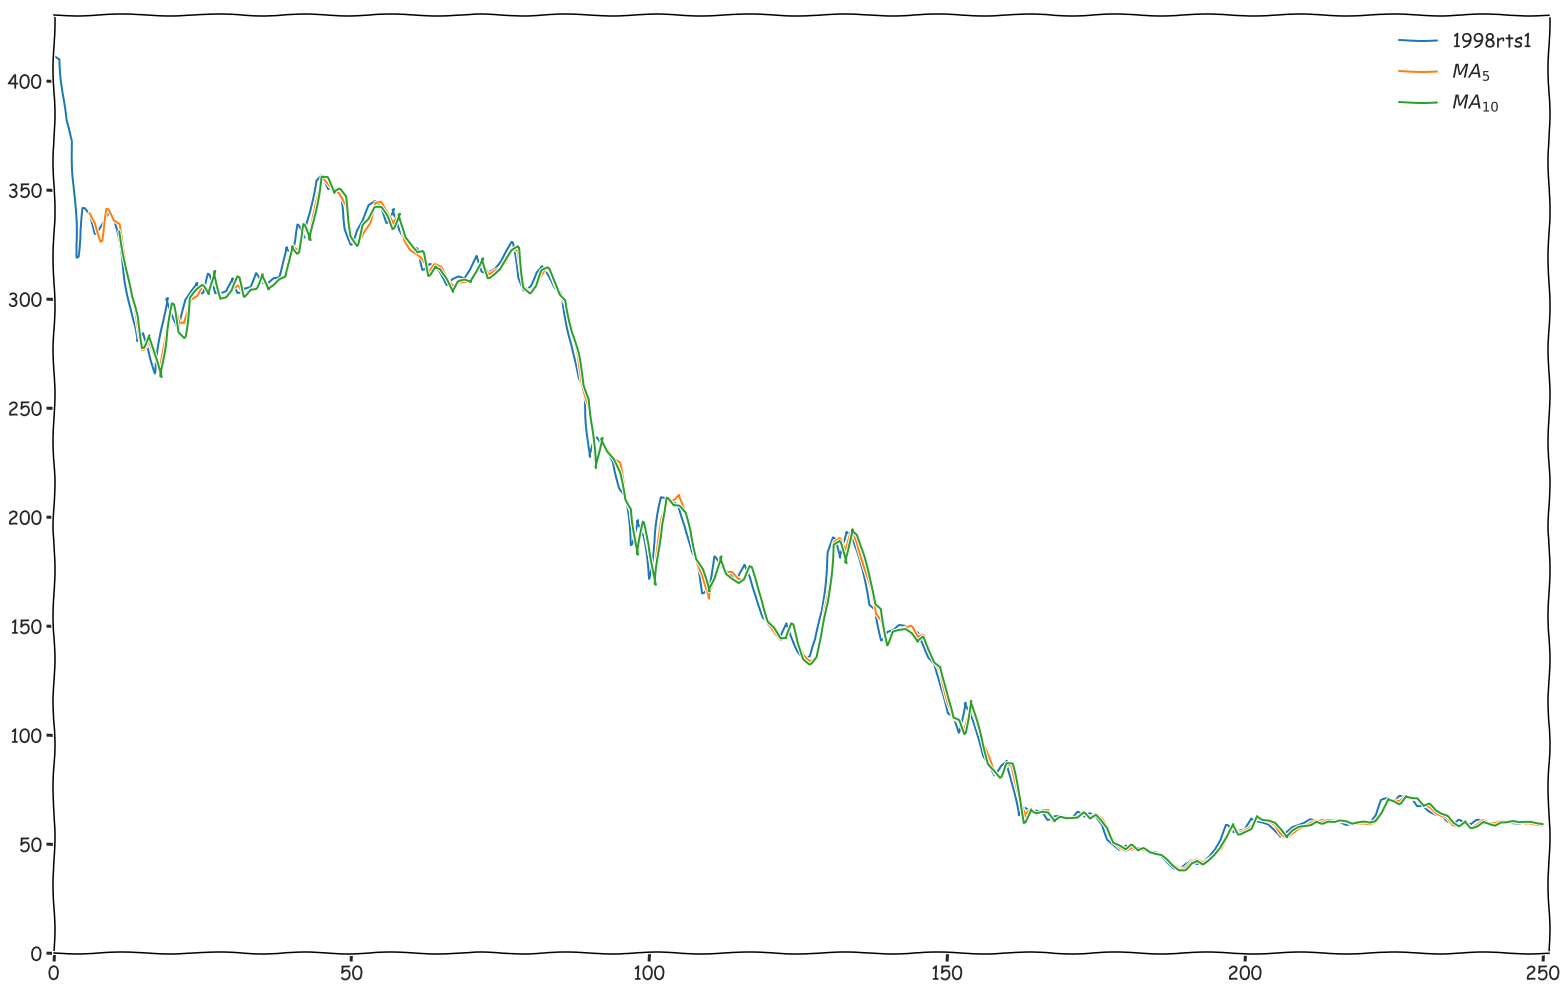

In [29]:
# key_to_show = MA_normal_5
_ = display(Markdown("### Графічне зображення передбичення по простому MA відносно Часового рядку"))

key_to_show = 'Predictions'
plotter(
    [df.values, "{}rts1".format(file)],
    [df_ma_5[key_to_show].values, "$MA_5$"],
    [df_ma_10[key_to_show].values, "$MA_{10}$"], 
)

### Графічне зображення передбичення по експоненційному MA відносно Часового рядку

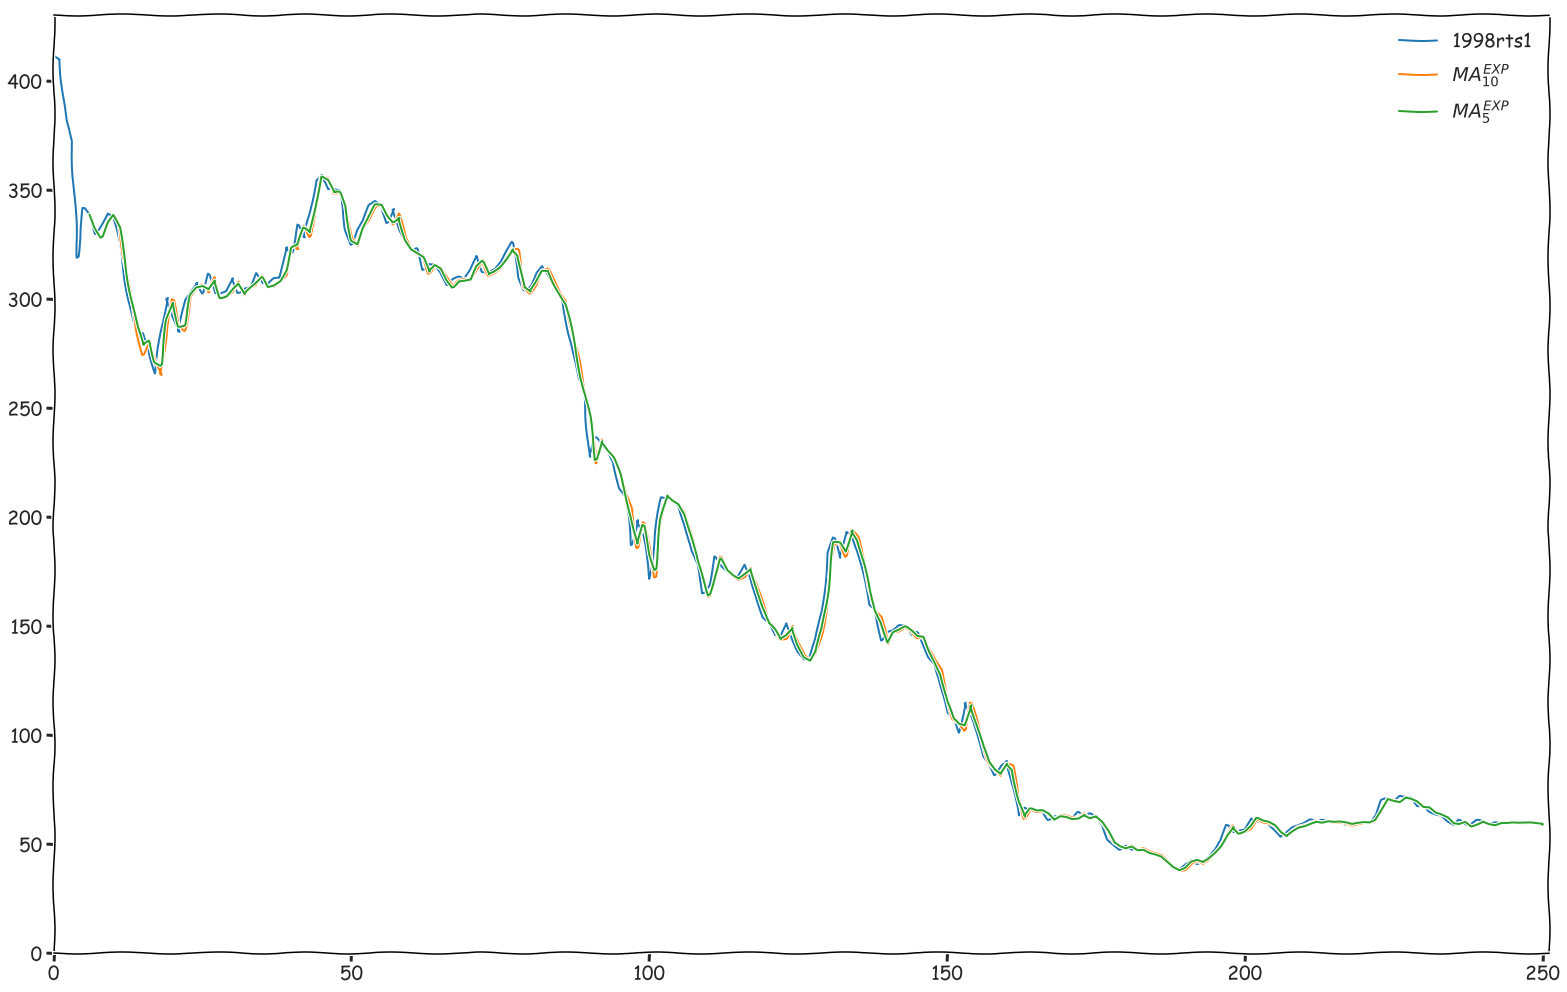

In [30]:
_ = display(Markdown("### Графічне зображення передбичення по експоненційному MA відносно Часового рядку"))

# key_to_show = MA_normal_5
key_to_show = 'Predictions'
plotter(
    [df.values, "{}rts1".format(file)], 
    [df_exp_10[key_to_show].values, "$MA_{10}^{EXP}$"],
    [df_exp_5[key_to_show].values, "$MA_{5}^{EXP}$"],
)

### Графічне зображення по усіх рівняннях MA відносно Часового рядку

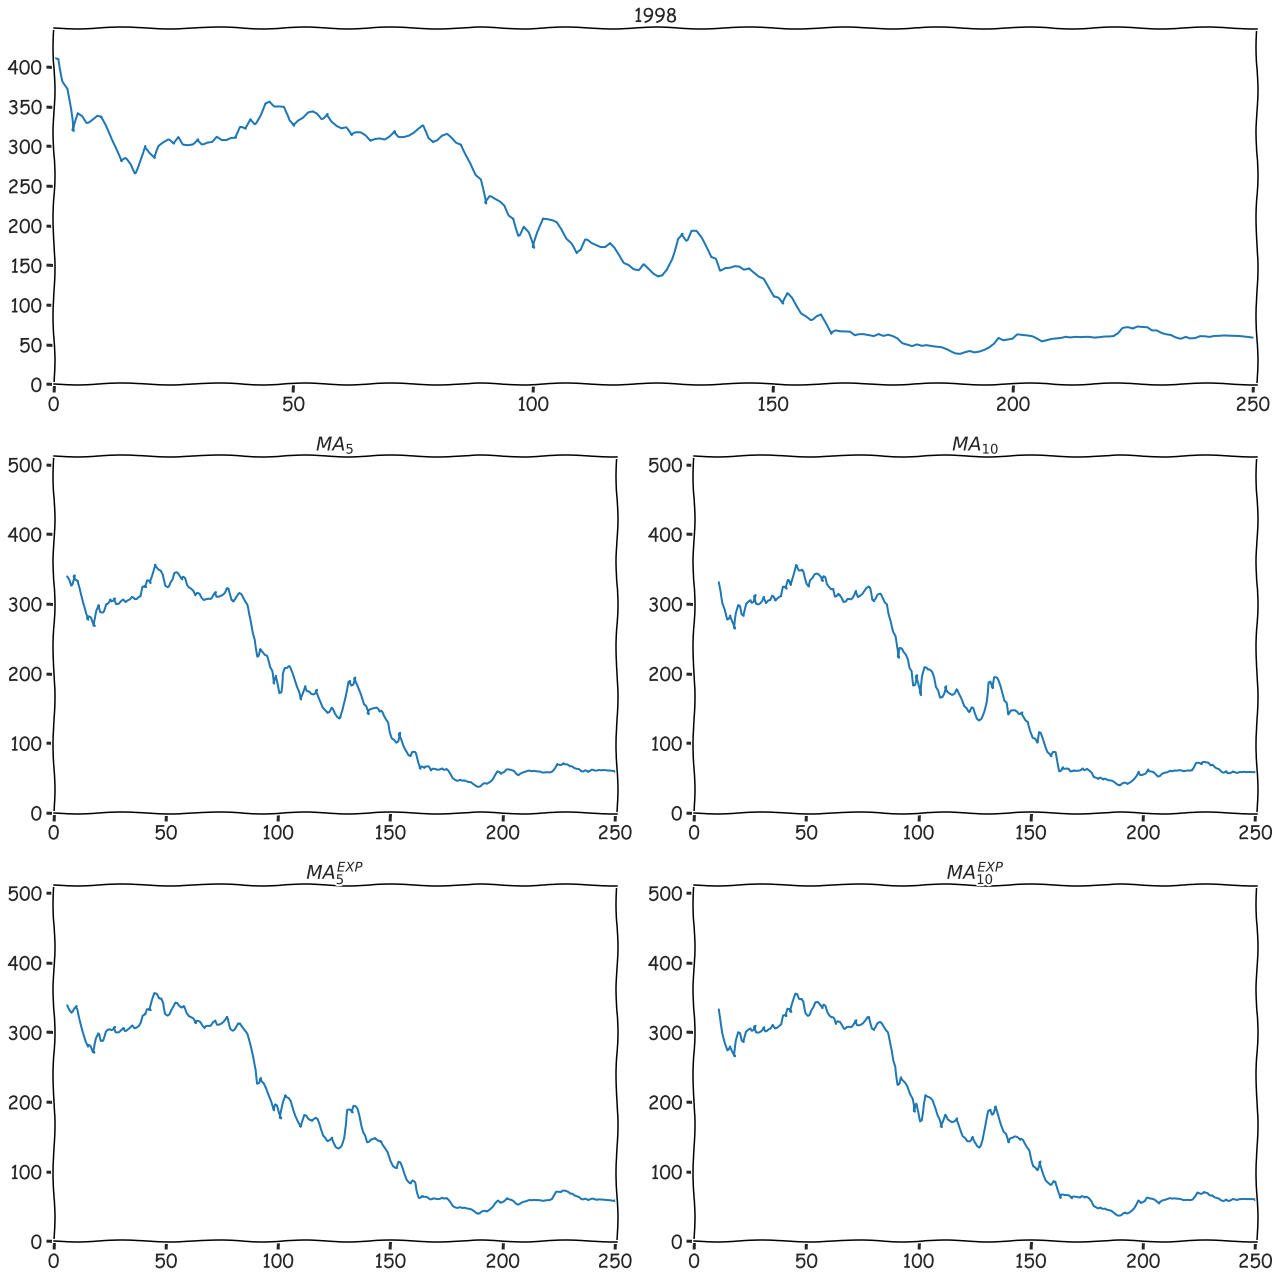

In [31]:
_ = display(Markdown("### Графічне зображення по усіх рівняннях MA відносно Часового рядку"))

allplots(df.values, predictions=[
    [df_ma_5[key_to_show].values, "$MA_5$"],
    [df_ma_10[key_to_show].values, "$MA_{10}$"],
    [df_exp_5[key_to_show].values, "$MA_{5}^{EXP}$"], 
    [df_exp_10[key_to_show].values, "$MA_{10}^{EXP}$"], 
], title="{}".format(file), figsize=(18,18))